
 Import Libraries

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np


In [ ]:
n# Download MovieLens 100k dataset
!wget -nc https://files.grouplens.org/datasets/movielens/ml-100k/u.data

# Load the dataset
columns = ['user', 'item', 'rating', 'timestamp']
data = pd.read_csv('u.data', sep='\t', names=columns)
data = data.drop('timestamp', axis=1)


--2025-05-25 18:31:58--  https://files.grouplens.org/datasets/movielens/ml-100k/u.data
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1979173 (1.9M)
Saving to: ‘u.data’

u.data              100%[===================>]   1.89M  2.50MB/s    in 0.8s    

2025-05-25 18:31:59 (2.50 MB/s) - ‘u.data’ saved [1979173/1979173]



In [ ]:
# Encode user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
data['user'] = user_encoder.fit_transform(data['user'])
data['item'] = item_encoder.fit_transform(data['item'])

# Convert to tensors
user_tensor = torch.tensor(data['user'].values, dtype=torch.long)
item_tensor = torch.tensor(data['item'].values, dtype=torch.long)
rating_tensor = torch.tensor(data['rating'].values, dtype=torch.float32)


In [ ]:
# Create dataset and split into train and validation
dataset = TensorDataset(user_tensor, item_tensor, rating_tensor)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(MatrixFactorization, self).__init__()
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.item_embed = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_ids, item_ids):
        user_vecs = self.user_embed(user_ids)
        item_vecs = self.item_embed(item_ids)
        return (user_vecs * item_vecs).sum(1)


In [ ]:
num_users = data['user'].nunique()
num_items = data['item'].nunique()

model = MatrixFactorization(num_users, num_items)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [ ]:
epochs = 10
val_rmses = []

for epoch in range(epochs):
    model.train()
    for user_ids, item_ids, ratings in train_loader:
        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for user_ids, item_ids, ratings in val_loader:
            outputs = model(user_ids, item_ids)
            val_loss += criterion(outputs, ratings).item()

    rmse = torch.sqrt(torch.tensor(val_loss / len(val_loader)))
    val_rmses.append(rmse.item())
    print(f"Epoch {epoch+1}: RMSE = {rmse.item():.4f}")


Epoch 1: RMSE = 4.1028
Epoch 2: RMSE = 2.6776
Epoch 3: RMSE = 2.2171
Epoch 4: RMSE = 2.0108
Epoch 5: RMSE = 1.8032
Epoch 6: RMSE = 1.6240
Epoch 7: RMSE = 1.4747
Epoch 8: RMSE = 1.4244
Epoch 9: RMSE = 1.3864
Epoch 10: RMSE = 1.3474


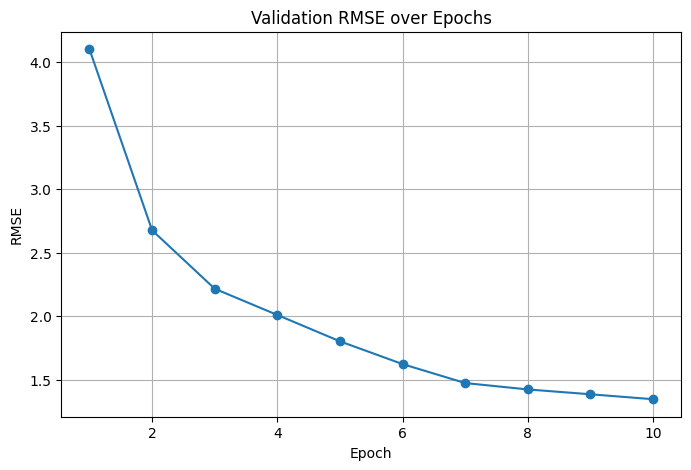

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), val_rmses, marker='o')
plt.title('Validation RMSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


<ipython-input-28-547304fc4b4f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data['rating'], palette="viridis")


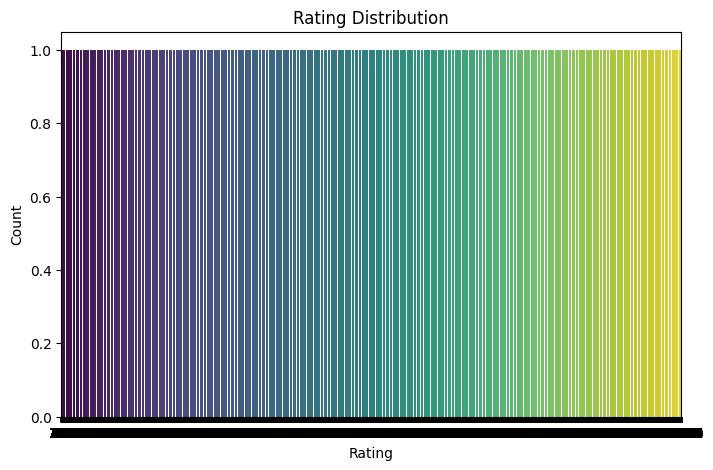

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data['rating'], palette="viridis")
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


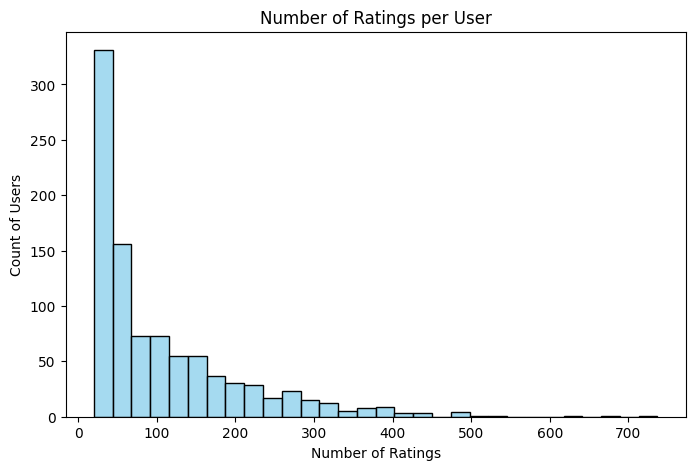

In [ ]:
plt.figure(figsize=(8, 5))
user_rating_counts = data.groupby('user').size()
sns.histplot(user_rating_counts, bins=30, kde=False, color='skyblue')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()


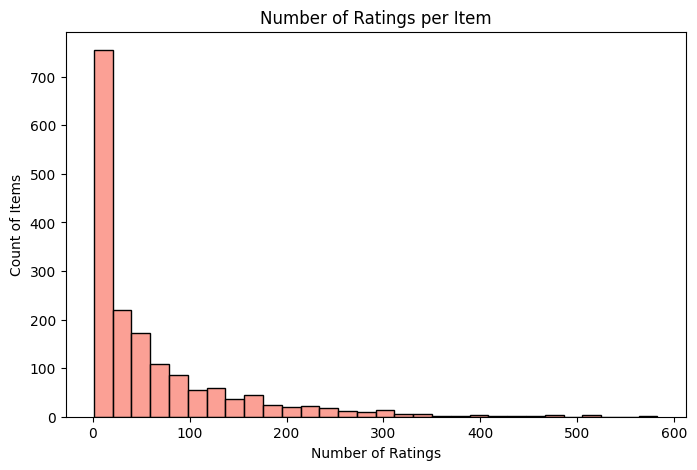

In [ ]:
plt.figure(figsize=(8, 5))
item_rating_counts = data.groupby('item').size()
sns.histplot(item_rating_counts, bins=30, kde=False, color='salmon')
plt.title('Number of Ratings per Item')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Items')
plt.show()


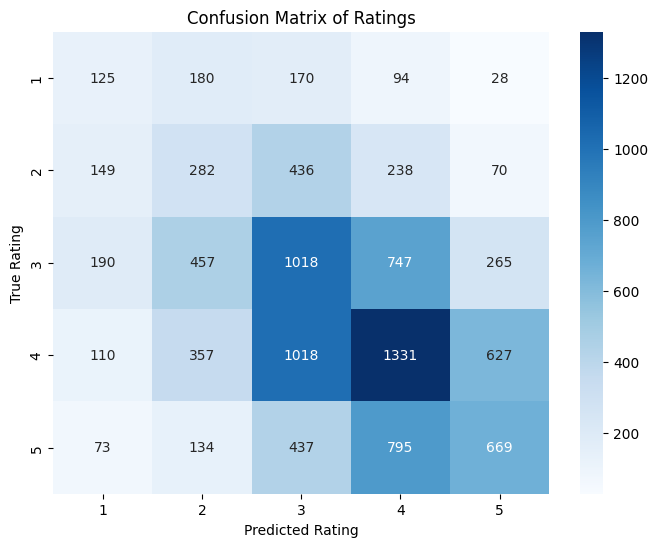

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Prepare tensors for entire validation set predictions and true ratings
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for user_ids, item_ids, ratings in val_loader:
        outputs = model(user_ids, item_ids)
        all_preds.extend(outputs.round().clamp(1, 5).tolist())  # Clamp to rating scale 1-5
        all_true.extend(ratings.tolist())

# Compute confusion matrix
cm = confusion_matrix(all_true, all_preds, labels=[1, 2, 3, 4, 5])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted Rating')
plt.ylabel('True Rating')
plt.title('Confusion Matrix of Ratings')
plt.show()


In [ ]:
correct_fuzzy = sum(abs(p - t) <= 1 for p, t in zip(all_preds, all_true))
accuracy_fuzzy = correct_fuzzy / total
print(f'Validation Accuracy (Within ±1 rating): {accuracy_fuzzy*100:.2f}%')


Validation Accuracy (Within ±1 rating): 78.34%
